In [0]:
spark


SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
import pyspark

In [0]:
file_path = "/FileStore/tables/intergenomic_seqs.csv"
temp_df = spark.read.option("delimiter", ",").option("header", "true").csv(file_path)

In [0]:
temp_df.show(3)

+-----+------+--------+--------+------+
|   id|region|   start|     end|strand|
+-----+------+--------+--------+------+
|27434|  chr2|56478034|56478234|     +|
|13400| chr21|20427531|20427731|     +|
|  883| chr17|73975959|73976159|     +|
+-----+------+--------+--------+------+
only showing top 3 rows



#### Column Breakdown

* ID: This column represents a unique identifier.

* Region: This indicates the chromosome number. In humans, chromosomes are numbered from 1 to 22, plus the sex chromosomes X and Y.

* Start: This is the start position of the genomic interval on the given chromosome (in base pairs)

* End: This is the end position of the genomic interval (also in base pairs).

* Strand: This refers to the strand on which the feature is located. In this case, + means the positive (or forward) strand, while - would indicate the negative (or reverse) strand.


In [0]:
# Starting with cleaning the data

from pyspark.sql import functions as F

# Removing duplicates
clean_df = temp_df.dropDuplicates()

# Filling missing values
clean_df = clean_df.fillna({
    "region": "unknown",    
    "start": 0,            
    "end": 0,              
    "strand": "+"          
})

# Filter out rows where start is greater than end
clean_df = clean_df.filter(F.col("start") <= F.col("end"))


# Show cleaned data
clean_df.show(5)

+-----+------+---------+---------+------+
|   id|region|    start|      end|strand|
+-----+------+---------+---------+------+
|  874|  chr8|108126287|108126487|     +|
|13400| chr21| 20427531| 20427731|     +|
|27434|  chr2| 56478034| 56478234|     +|
| 7303| chr13| 45730273| 45730473|     +|
|45124| chr10| 38820750| 38820950|     +|
+-----+------+---------+---------+------+
only showing top 5 rows



In [0]:
# Calculating the interval length
clean_df = clean_df.withColumn("interval_length", F.col("end") - F.col("start"))

# Show the transformed data with interval length
clean_df.select("id", "start", "end", "interval_length").show(25)

+-----+---------+---------+---------------+
|   id|    start|      end|interval_length|
+-----+---------+---------+---------------+
|45261| 46678568| 46678768|          200.0|
|15621| 98928685| 98928885|          200.0|
|21189|  9550000|  9550200|          200.0|
|29935| 86636303| 86636503|          200.0|
| 8313|109028412|109028612|          200.0|
| 4705| 88195081| 88195281|          200.0|
| 1549| 74700985| 74701185|          200.0|
|42859| 62780147| 62780347|          200.0|
|19863|  2894096|  2894296|          200.0|
|21335| 47763080| 47763280|          200.0|
|28238| 60265127| 60265327|          200.0|
|19031| 71557043| 71557243|          200.0|
| 9682|  2489564|  2489764|          200.0|
|28233|165141523|165141723|          200.0|
|17617| 57839255| 57839455|          200.0|
|30634| 12349280| 12349480|          200.0|
|24822|117398404|117398604|          200.0|
|41591| 27329882| 27330082|          200.0|
|39593| 59715651| 59715851|          200.0|
|48532| 52007686| 52007886|     

In [0]:
# Inserting a description column

new_col_clean_df = clean_df.withColumn(
    "Sex Chromosome", 
    F.when(F.col("region").isin("chr1", "chr2"), "Y").otherwise("N")
    )

In [0]:
sorted_df = new_col_clean_df.sort("region", ascending=[True]) 

In [0]:
sorted_df.createOrReplaceTempView("genomics_data")

In [0]:
# Displaying the transformed data

query_result = spark.sql("""
    SELECT * 
    FROM genomics_data
""")

# Show the result
query_result.show(10)

+-----+------+---------+---------+------+---------------+--------------+
|   id|region|    start|      end|strand|interval_length|Sex Chromosome|
+-----+------+---------+---------+------+---------------+--------------+
|35324|  chr1|191257717|191257917|     +|          200.0|             Y|
|21982|  chr1|187892834|187893034|     +|          200.0|             Y|
|14010|  chr1|223177476|223177676|     +|          200.0|             Y|
|31229|  chr1|195691623|195691823|     +|          200.0|             Y|
|21863|  chr1| 90090589| 90090789|     +|          200.0|             Y|
|26496|  chr1|103192956|103193156|     +|          200.0|             Y|
|44548|  chr1| 38532491| 38532691|     +|          200.0|             Y|
|40219|  chr1|196635646|196635846|     +|          200.0|             Y|
|36496|  chr1|104467447|104467647|     +|          200.0|             Y|
|29495|  chr1|220432128|220432328|     +|          200.0|             Y|
+-----+------+---------+---------+------+----------

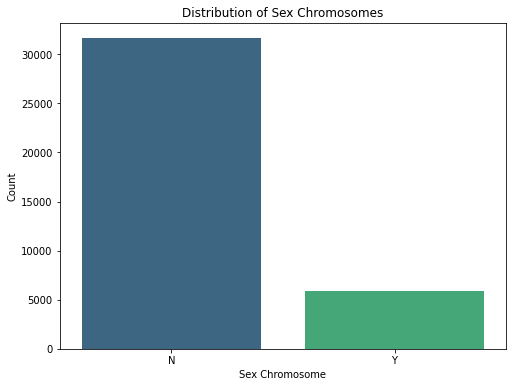

In [0]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = new_col_clean_df.toPandas()
plt.figure(figsize=(8, 6))
sns.countplot(data=pandas_df, x='Sex Chromosome', palette='viridis')
plt.title('Distribution of Sex Chromosomes')
plt.xlabel('Sex Chromosome')
plt.ylabel('Count')
plt.show()

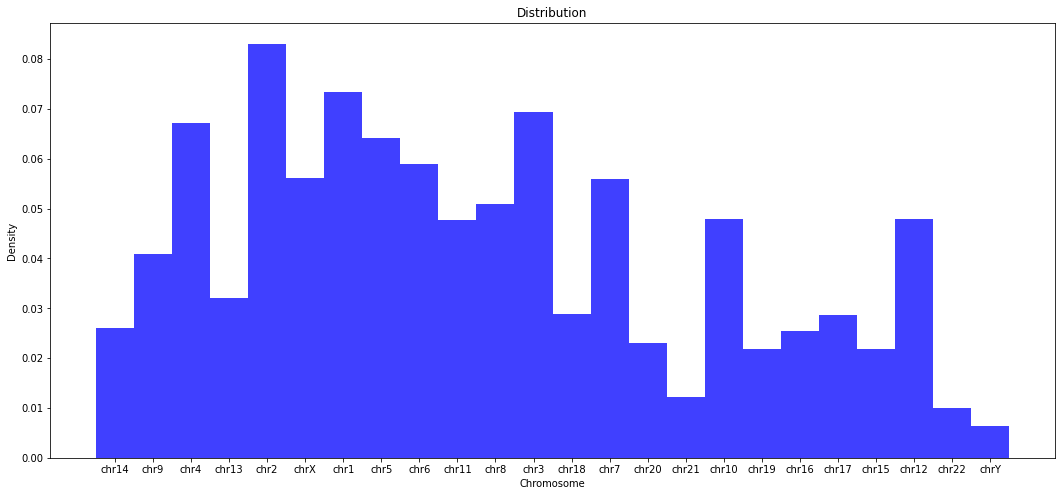

In [0]:
plt.figure(figsize=(18, 8))
sns.histplot(pandas_df['region'], color='blue', stat="density", linewidth=0)
plt.title('Distribution')
plt.xlabel('Chromosome')
plt.ylabel('Density')
plt.show()

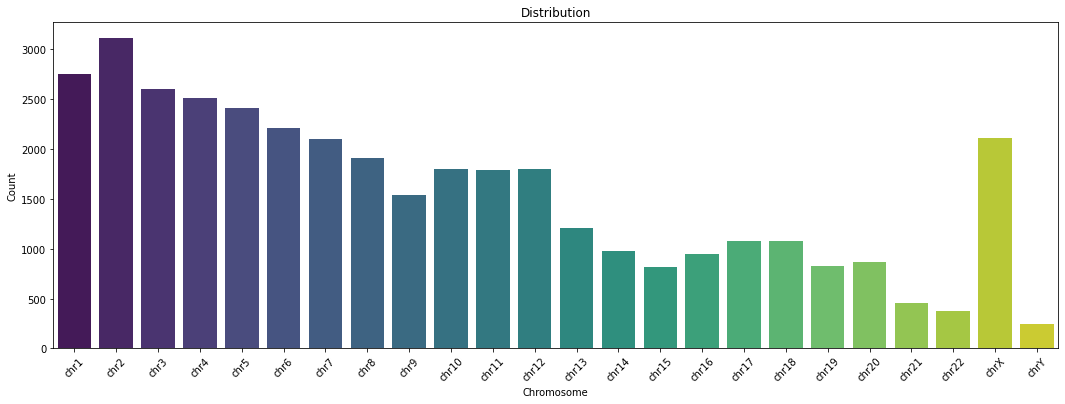

In [0]:

chromosome_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY' ]

# Create a bar plot
plt.figure(figsize=(18, 6))
sns.barplot(data=region_counts, x='region', y='count', order=chromosome_order, palette='viridis')

# Add titles and labels
plt.title('Distribution')
plt.xlabel('Chromosome')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()